## Dataset split using `os.symlink()`

When working with large datasets consisting of separate files, we can manage dataset splits with symbolic links, essentially creating shortcuts to original files according to a desired split ratio.

The advantage is we don't need to copy or move files around, as these operations require extra computation and memory usage.  

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

%matplotlib inline

print(os.getcwd())

datapath = "images/"

c:\Users\tomas\Documents\setit\insect-identification\code


In [4]:
# read category from filename
filename = "0_00213.jpg"
category = filename.split("_")[0]
print(category)

0


### Get labels

In [5]:
# read in `classes.txt.txt` with proper class names into a dict.
# these could do with a bit of sanitation.
labels = {}

with open('classes.txt.txt') as f:
    for line in f:
        # remove lead/trailing whitespace 
        stripped = line.strip()
        # collect the parts of the names together with *
        head, *rest = stripped.split()

        # we can do -1 here since our images are classed 0-101
        key = int(head) -1
        
        val = rest
        # join the names with an underscore
        labels[key] = '_'.join(val)

labels

FileNotFoundError: [Errno 2] No such file or directory: 'classes.txt.txt'

In [1]:
# # alternatively the dictionary comprehension way
# with open("classes.txt.txt") as f:
#     a = {int(k)-1: '_'.join(v.split()) for line in f for (k,v) in [line.strip().split(None, 1)]}
# a

### Data exploration & split 

- read original splits from .csvs and select matching filenames
- custom split:
    * get lengths of each class subset (# of samples per label)
    * 

In [14]:
# https://github.com/MLWhiz/data_science_blogs/blob/master/compvisblog/Boats_DataExploration.ipynb

# print(labels)

file_list = [] 
for (dirpath, dirnames, filenames) in os.walk(datapath):
    file_list.extend(filenames)

# # or
# images = []
# for image in os.listdir(datapath):
#     images.append(image)

# print(len(images))
# print(images[0], images[-1])

In [6]:
# dict with filename as key, class as value
images = {}
for image in os.listdir(datapath):
    (val, key) = image.split("_")
    images[key] = val

# get file counts per class
from collections import Counter

images_per_class = Counter(images.values())

# accessing particular class 
counts_20 = images_per_class['20']

#print(counts_20, '\n')
#print(images_per_class)

# sort descending according to count

sorted_desc = sorted(images_per_class.items(), key=lambda x:x[1], reverse = True)

df = pd.DataFrame(sorted_desc, columns=["classID","Image count"])

df

,classID,Image count
0,101,5740
1,67,5310
2,70,5081
3,24,4094
4,51,1897
...,...,...
97,98,93
98,63,84
99,61,79
100,80,74


<AxesSubplot:title={'center':'IP102, images per target class'}>

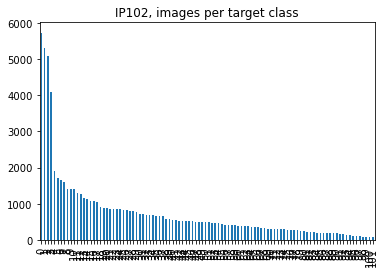

In [7]:
df["Image count"].plot.bar(title="IP102, images per target class")


### custom data split

In [ ]:
# set target ratios for split. E.g., train=0.75, val=0.15, test=0.10.

# calculate the length of each subset. E.g., train_length =  0.75 * len(entire set)

# do a stratified sample of the desired size for each subset. for example sklearn Subset??
# https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/5

### original data split from .csvs

In [19]:
# read in filenames from csvs containing original data splits

train_files = []
with open('train.txt') as f:
    for line in f:
        train_files.append(line.split(" ")[0])

val_files = []
with open('val.txt') as f:
    for line in f:
        val_files.append(line.split(" ")[0])

test_files = []
with open('test.txt') as f:
    for line in f:
        test_files.append(line.split(" ")[0])

print("length of training subset:", len(train_files))
print("length of validation subset:", len(val_files))
print("length of test subset:", len(test_files))        

length of training subset: 45095
length of validation subset: 7508
length of test subset: 22619


In [2]:
# get paths of images in each subset by matching filenames 
# get rid of class prefix here with .split("_")[1]
stripped_filenames = {file.split("_")[1] for file in file_list}

matches = []
for file in train_files:
    if file in stripped_filenames:
        # print('found', file)
        matches.append(file)
print(len(matches))

NameError: name 'file_list' is not defined

### creating symlinks

In [4]:
# create folder structure to hold split sets
dataset = "split/"
#os.mkdir(dataset)

dirs = ["train", "test", "val"]

train_path = os.path.join(dataset, "train")
val_path = os.path.join(dataset, "val")
test_path = os.path.join(dataset, "test")

##os.mkdir(train_path)
#os.mkdir(val_path)
#os.mkdir(test_path)

- Make folders for each class in each dataset folder
- using `os.symlink()`, add links to original files in corresponding class folder in each dataset folder

functionalised making of symlinks

- (locally tested) Now properly creates split/phase/class folders in the right place and symlink for provided source file.

- `create_link(src, phase)`
-  `src` being an absolute path, `phase` being a string of 'train', 'val' or 'test'

In [27]:
dataset = "split/"
os.mkdir(dataset)
src_abs = os.path.abspath(src)


def create_link(src, phase):

    # check src
    if os.path.isfile(src):
        print('source exists')
        base_path = os.path.relpath(dataset)

        print("base_path: ", base_path)
        
        
        # determine class index from filename
        head_tail = os.path.split(src)

        label_index = int(head_tail[1].split('_')[0])
        print(label_index)

        img_filename_only = head_tail[1]

        labelname = labels[label_index]
        print('class index of source: {}, labelname: {}'.format(label_index, labelname))
        phase_path = os.path.join(base_path, phase)
        print("phase path: '%s'" % phase_path)

        # if phase path doesn't exist, it needs to be made
        if not os.path.isdir(phase_path):
            print("making phase directory...")
            os.mkdir(phase_path)

        dest_folder_path = os.path.join(phase_path, labelname)
        print("dest folder path: {}, is abs: {}".format(dest_folder_path, os.path.isabs(dest_folder_path)))

        # if destination folder doesn't exist, make it
        if not os.path.exists(dest_folder_path):
             print("making class directory...")
             os.mkdir(dest_folder_path)
        
        # create destination path
        link_path = os.path.join(dest_folder_path, img_filename_only)
        link_path = os.path.relpath(link_path)
        print("link path:", link_path)
        
        # make link
        print("making symlink at", link_path)
        os.symlink(src, link_path)
        

    else:
        print('src file not found')


create_link(src_abs, "train")

source exists
base_path:  split
0
class index of source: 0, labelname: rice_leaf_roller
phase path: 'split\train'
making phase directory...
dest folder path: split\train\rice_leaf_roller, is abs: False
making class directory...
link path: split\train\rice_leaf_roller\0_00005.jpg
making symlink at split\train\rice_leaf_roller\0_00005.jpg
